Here, I test whether my LSTM net works or not to estimate SGM parameters

I use the simulated data not the truth MEG

- As I use SGM_Net trained for 36-MEG data, I should use the same freqs 

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
from joblib import Parallel, delayed
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.stable import paras_stable_check
from models.lstm import LSTM_SGM
from models.model_utils import weights_init
from models.loss import  weighted_mse_loss, reg_R_loss, lin_R_loss, lin_R_fn, reg_R_fn
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

df_dtype = torch.float32
torch.set_default_dtype(df_dtype)
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_device("cpu")

In [7]:
seed = 1
import random
random.seed(seed)
np.random.seed(seed);
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True); 

# Data, fn and paras

In [8]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc")) # 300/150
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all_full = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale, 
# make it num_sub x num_roi x num_freqs x num_ts
psd_all_full = psd_all_full.transpose(3, 0, 1, 2)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [9]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [10]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [11]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 360
paras_run.n_sub = 50
# note k can differ from SGM_net
paras_run.k = 1.0 # the parameter for reparameterization in logistic
#paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

# to generate ARMA TS
from statsmodels.tsa.arima_process import arma_generate_sample

def gen_arma_ts(n, ndim=7):
    """Generate ARMA ndim-vec ts.
    """
    # ARMA(2, 2)
    ys = []
    for ix in range(ndim):
        arparams = np.array([.75, -.25])
        maparams = np.array([.65, .35])
        ar = np.r_[1, -arparams] # add zero-lag and negate
        ma = np.r_[1, maparams] # add zero-lag
        y = arma_generate_sample(ar, ma, n)
        ys.append(y)
    return np.array(ys)

# Generate simulated data

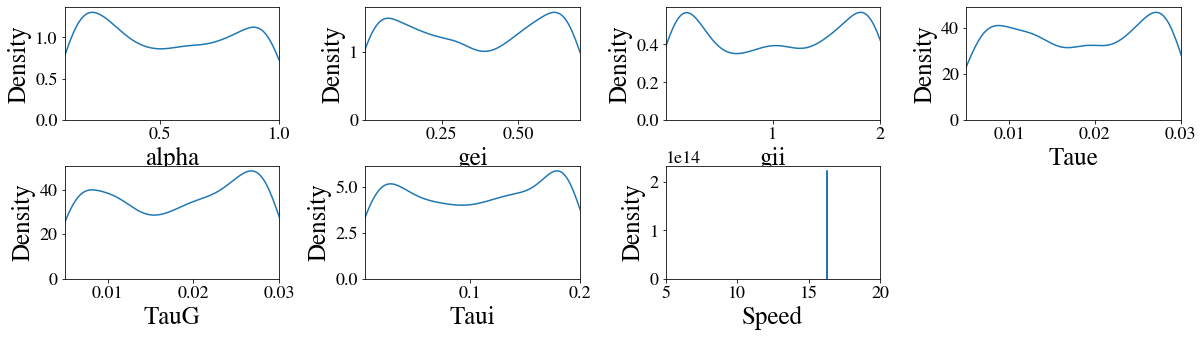

In [48]:
# show demo of generatingt simulation data (Speed is a constant, Mar 30, 2023)
if not RUN_PYTHON_SCRIPT:
    ts_nospeed = gen_arma_ts(1000, 6).T
    ts_speed = np.repeat(np.random.randn(1), 1000)
    sgm_paramss_raw = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
    sgm_paramss = raw2theta_np(sgm_paramss_raw, paras.prior_bds, k=paras_run.k)
    
    plt.figure(figsize=[20, 5])
    for ix in range(7):
        plt.subplot(2, 4, ix+1)
        sns.kdeplot(sgm_paramss[:, ix])
        plt.xlim(paras.prior_bds[ix, :])
        plt.xlabel(paras.names[ix])

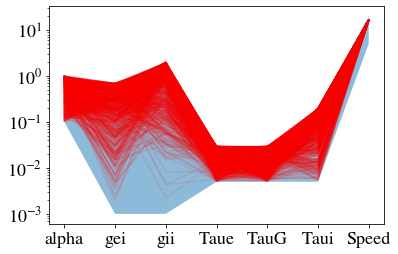

In [49]:
#check the reparameterization
if not RUN_PYTHON_SCRIPT:
    plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
    plt.yscale("log")
    for cur_ts_sgm in sgm_paramss:
        plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
    plt.xticks(np.arange(7), paras.names);
    plt.show()
    plt.close()

In [14]:
# Gerenate data when speed is a constant
sgm_paramsss = []
PSDss = []
for sub_ix in range(paras_run.n_sub):
    ts_dyn = gen_arma_ts(paras_run.n, 3).T
    ts_taus = np.repeat(np.random.randn(3)[:, None], paras_run.n, axis=1).T
    ts_speed = np.repeat(np.random.randn(1), paras_run.n)
    sgm_paramss_raw = np.concatenate([ts_dyn, ts_taus, ts_speed.reshape(-1, 1)], axis=1)
    
    sgm_paramss = raw2theta_np(sgm_paramss_raw, paras.prior_bds, k=paras_run.k)
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    def _run_fn(cur_sgm):
        cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
        cur_PSD = cur_PSD[:68, :]
        return cur_PSD
    with Parallel(n_jobs=20) as parallel:
        PSDs = parallel(delayed(_run_fn)(cur_sgm) for cur_sgm in tqdm(sgm_paramss, 
                                                                      desc=f"sub {sub_ix+1}/{paras_run.n_sub}", 
                                                                      total=paras_run.n))
    sgm_paramsss.append(sgm_paramss)
    PSDss.append(PSDs)
    
simu_sgm_data = edict()
simu_sgm_data.PSDss = np.array(PSDss)
simu_sgm_data.sgm_paramsss =sgm_paramsss
save_pkl_dict2folder(RES_ROOT/f"simu_ts_sgm_data_contauspeed", simu_sgm_data, is_force=False)

sub 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:09<00:00, 36.06it/s]


/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed/PSDss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed/sgm_paramsss.pkl


# Train the model

In [12]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_ts_sgm_data_contauspeed");

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed/PSDss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed/sgm_paramsss.pkl


In [13]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net", excluding=['opt*']);
sgm_net = trained_model.model
sgm_net.to(dtype=df_dtype);
sgm_net.eval();

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl


In [48]:
def _evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data, dtype=df_dtype).transpose(1, 0)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    with torch.no_grad():
        Y_pred, _ = rnn(all_data_input);
        X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = reg_R_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(len_seq, num_sub, -1).transpose(1, 0)
    return corrs.detach().numpy()

In [32]:
paras_rnn = edict()
paras_rnn.niter = 1000 #!!!! 500
paras_rnn.loss_out = 1
paras_rnn.loss_pen_w = 1
paras_rnn.eval_out = 20
paras_rnn.clip = 1 # from 
paras_rnn.lr_step = 10 #!!!! 300
paras_rnn.gamma = 0.9 #!!!! 0.5
paras_rnn.lr = 1e-4 

paras_rnn.k = 1
paras_rnn.hidden_dim = int(1024/4)
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*len(paras.freqs)
paras_rnn.is_bidirectional = False #!!!!False
paras_rnn.unstable_pen = 10000 # Whether to filter out the unstable sps or not, if 0 not, if large number, yes
paras_rnn.loss_name = "linR" # linR, corr, wmse or mse
#paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]
# 1 dynamic, 0 static
paras_rnn.dy_mask = [1, 1, 1, 1, 1, 1, 0] 
post_fix = "_datataufixed"
stat_part = "_".join(np.array(paras.names)[np.array(paras_rnn.dy_mask)==0][:-1])
if len(stat_part) > 0:
    folder_name = f"LSTM_simu_net_simudata_{paras_rnn.loss_pen_w*10}_{paras_rnn.loss_name}_{stat_part}{post_fix}";
else:
    folder_name = f"LSTM_simu_net_simudata_{paras_rnn.loss_pen_w*10}_{paras_rnn.loss_name}{post_fix}";
paras_rnn.save_dir = RES_ROOT/folder_name
print(paras_rnn.save_dir)


#  all_data should be num_sub x len_seq x nrois x nfreqs
#  or len_seq x nrois x nfreqs
all_data = simu_sgm_data.PSDss

all_data_raw = torch.tensor(all_data, dtype=df_dtype).transpose(1, 0)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_linR_datataufixed


In [33]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds, dtype=df_dtype), 
               k = paras_rnn.k, 
               dy_mask = paras_rnn.dy_mask
)
rnn.apply(weights_init)
rnn.to(dtype=df_dtype);
if paras_rnn.loss_name.startswith("corr"):
    loss_fn = reg_R_loss
elif paras_rnn.loss_name.startswith("linR"):
    loss_fn = lin_R_loss
elif paras_rnn.loss_name.startswith("wmse"):
    loss_fn = weighted_mse_loss
elif paras_rnn.loss_name.startswith("mse"):
    loss_fn = nn.MSELoss()
else:
    raise KeyError("No such loss")

optimizer = torch.optim.AdamW(rnn.parameters(), lr=paras_rnn.lr, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=paras_rnn.gamma, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [45]:
theta_pred.shape

torch.Size([360, 50, 7])

In [34]:
# training
loss_cur = 0
loss_pen_cur = 0
losses = []
losses_pen = []
losses_test = []

t0 = time.time()
sgm_net.eval()
loss_add = 0
for ix in range(paras_rnn.niter):
    rnn.train()
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred, loss_pen = rnn(X_seq)
    loss_pen = loss_pen[rnn.dy_mask==1].mean()
    #tmp = theta_pred.detach().numpy()
    #print((tmp.std(axis=1)/tmp.mean(axis=1))[0], scipy.stats.pearsonr(tmp1[:, 0, -1], tmp[0, :, -1]))
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss_main = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    if paras_rnn.unstable_pen > 0:
        unstable_inds = paras_stable_check(theta_pred.flatten(0, 1).detach().numpy());
        unstable_inds = torch.tensor(unstable_inds).reshape(*theta_pred.shape[:2])
        loss_add = (paras_rnn.unstable_pen * unstable_inds.unsqueeze(-1) * theta_pred).mean();
    loss = loss_main + loss_add + paras_rnn.loss_pen_w * loss_pen
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()
    
    loss_cur = loss_cur + loss_main.item()
    loss_pen_cur = loss_pen_cur + loss_pen.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        losses_pen.append(loss_pen_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"the pen losses are {loss_pen_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        loss_pen_cur = 0
        t0 = time.time()
        
    if ix % paras_rnn.eval_out == (paras_rnn.eval_out-1):
        rnn.eval()
        loss_test = _evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


At iter 1/1000, the losses are -0.39167 (train). the pen losses are 0.00246 (train). The time used is 3.423s. 
At iter 2/1000, the losses are -0.39788 (train). the pen losses are 0.00201 (train). The time used is 3.321s. 
At iter 3/1000, the losses are -0.40240 (train). the pen losses are 0.00202 (train). The time used is 3.370s. 
At iter 4/1000, the losses are -0.40579 (train). the pen losses are 0.00212 (train). The time used is 3.409s. 
At iter 5/1000, the losses are -0.40849 (train). the pen losses are 0.00225 (train). The time used is 3.331s. 
At iter 6/1000, the losses are -0.41081 (train). the pen losses are 0.00231 (train). The time used is 3.326s. 
At iter 7/1000, the losses are -0.41261 (train). the pen losses are 0.00232 (train). The time used is 3.376s. 
At iter 8/1000, the losses are -0.41408 (train). the pen losses are 0.00231 (train). The time used is 3.373s. 
At iter 9/1000, the losses are -0.41549 (train). the pen losses are 0.00231 (train). The time used is 3.380s. 
A

KeyboardInterrupt: 

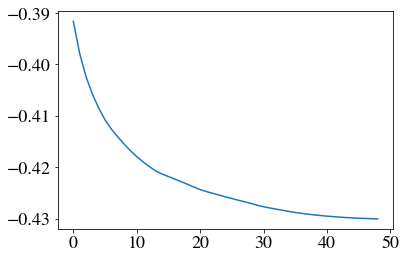

In [35]:
plt.plot(losses)
#plt.yscale("log")

In [36]:
rnn.eval()
with torch.no_grad():
    Y_pred, _ = rnn(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy().transpose(1, 0, 2);

In [37]:
sgm_paramss_est.shape

(50, 360, 7)

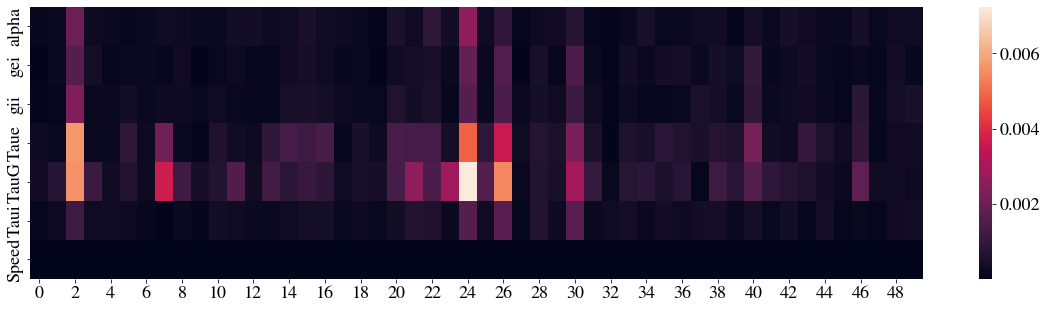

In [41]:
pred_params = sgm_paramss_est[:, 50:]
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

In [42]:
np.median(CVs, axis=0)

array([2.5500514e-04, 2.1344882e-04, 2.4962431e-04, 5.3481373e-04,
       7.6588005e-04, 2.5918568e-04, 2.5571994e-06], dtype=float32)

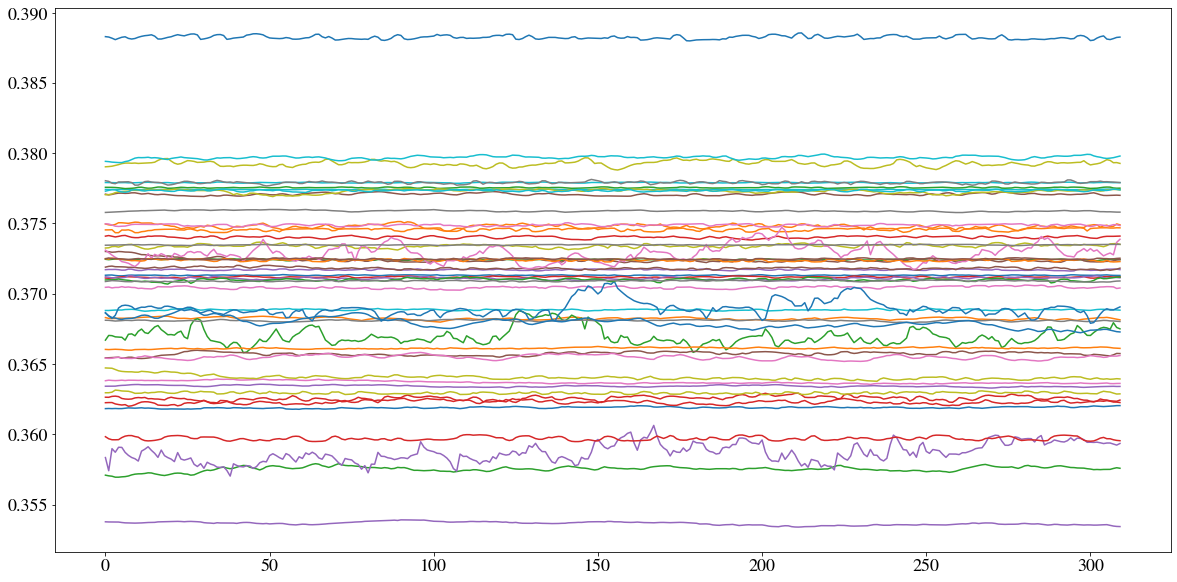

In [44]:
para_ix = 1
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

In [19]:
if (paras_rnn.save_dir).exists():
    trained_model = load_pkl_folder2dict(paras_rnn.save_dir)
else:
    trained_model = edict()
    trained_model.model = rnn
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_rnn
    trained_model.loss = losses
    save_pkl_dict2folder(paras_rnn.save_dir, trained_model, is_force=True)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss.pkl


In [20]:
trained_model.model.eval()
with torch.no_grad():
    Y_pred, _ = trained_model.model(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy().transpose(1, 0, 2)
trained_model.sgm_paramss_est = sgm_paramss_est
save_pkl_dict2folder(paras_rnn.save_dir, trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/model.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss_fn.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/optimizer.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/paras.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss.pkl exists! Use is_force=True to save it anyway
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufix

# Evaluate

## SGM parameters

In [21]:
#save_dir = RES_ROOT/"LSTM_simu_net_simudata_linR_Taue_TauG_Taui"
save_dir = RES_ROOT/"LSTM_simu_net_simudata_10_wmse_datataufixed"
trained_model = load_pkl_folder2dict(save_dir);
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_ts_sgm_data_contauspeed");

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net_simudata_10_wmse_datataufixed/sgm_paramss_est.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_ts_sgm_data_contauspeed/PSDss.pkl
Load file /data/rajl

In [22]:
true_params = np.array(simu_sgm_data.sgm_paramsss)
pred_params = trained_model.sgm_paramss_est;

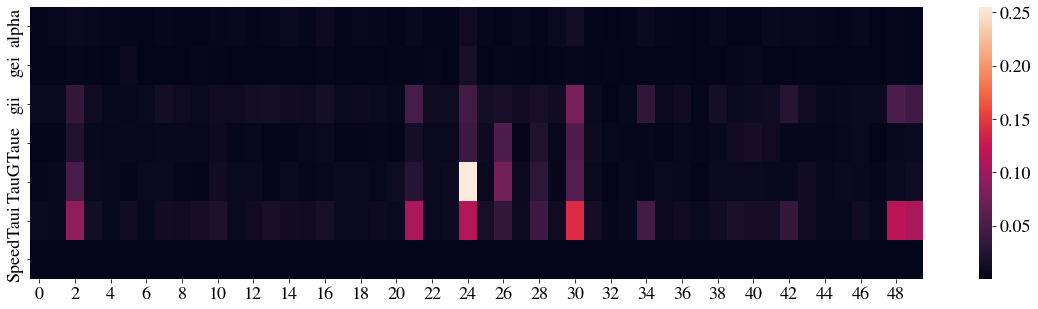

In [23]:
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

In [33]:
np.median(CVs, axis=0)

array([3.3581441e-03, 1.8144984e-03, 9.4542634e-03, 4.6935347e-03,
       6.3827382e-03, 1.1005222e-02, 1.9958750e-06], dtype=float32)

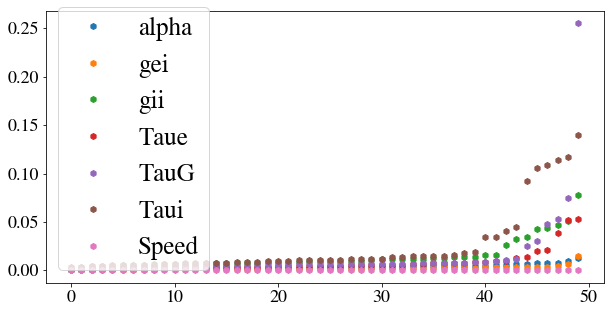

In [24]:
plt.figure(figsize=[10, 5])
for para_ix in range(7):
    plt.plot(np.sort(CVs[:, para_ix]), "h", label=f"{paras.names[para_ix]}")
plt.legend()

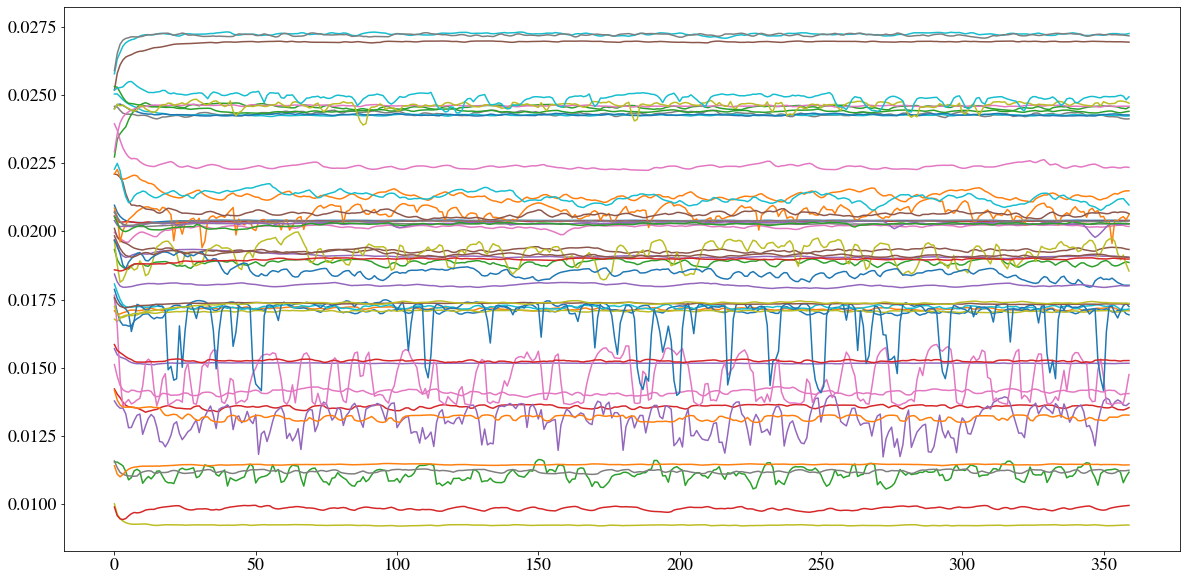

In [28]:
para_ix = 3
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

### Can recover truth?

In [29]:
dy_mask = np.array(trained_model.paras.dy_mask);

In [30]:
# not need speed
true_params_flt = true_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, true_params.shape[1])
pred_params_flt = pred_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, pred_params.shape[1]);
true_params_stat = true_params[:, 0, dy_mask==0]
pred_params_stat = pred_params[:, 0, dy_mask==0]
dyn_names = np.array(paras.names)[dy_mask==1]
stat_names = np.array(paras.names)[dy_mask==0]
num_dyn_params = (dy_mask==1).sum();

#### Static

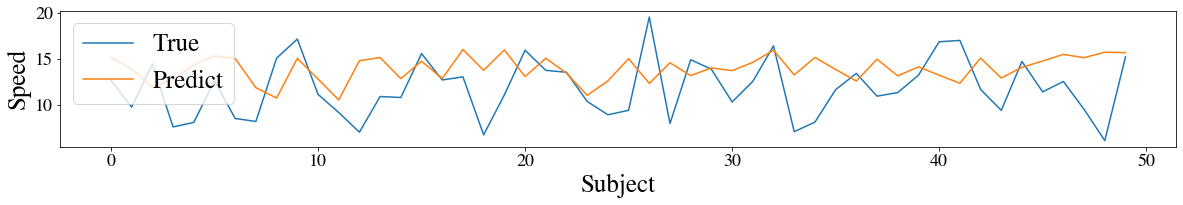

In [31]:
plt.figure(figsize=[20, 2.5*len(stat_names)])
for para_ix in range(len(stat_names)):
    plt.subplot(len(stat_names), 1, para_ix+1)
    plt.plot(true_params_stat[:, para_ix], label="True")
    plt.plot(pred_params_stat[:, para_ix], label="Predict")
    plt.xlabel("Subject")
    plt.ylabel(stat_names[para_ix])
    plt.legend()

#### Reg R

In [34]:

corrs = reg_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);
corrs1, pvals = [], []
for ix in range(true_params_flt.shape[0]):
    rv, pval = scipy.stats.pearsonr(true_params_flt[ix, :], pred_params_flt[ix, :])
    corrs1.append(rv)
    pvals.append(pval)
corrs1 = np.array(corrs1).reshape(-1, num_dyn_params)
pvals = np.array(pvals).reshape(-1, num_dyn_params);

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/loss.py:45: RuntimeWarning: invalid value encountered in true_divide
  corrs = num/den
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


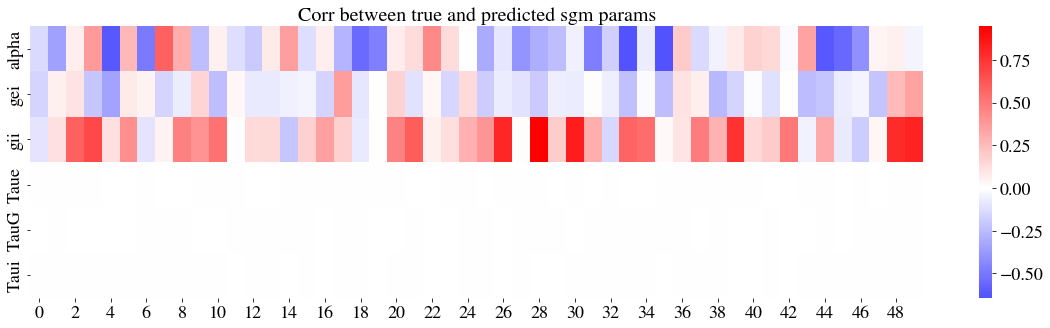

In [35]:
plt.figure(figsize=[20, 5])
plt.title(f"Corr between true and predicted sgm params", fontsize=20)
sns.heatmap(corrs.T, cmap="bwr", center=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

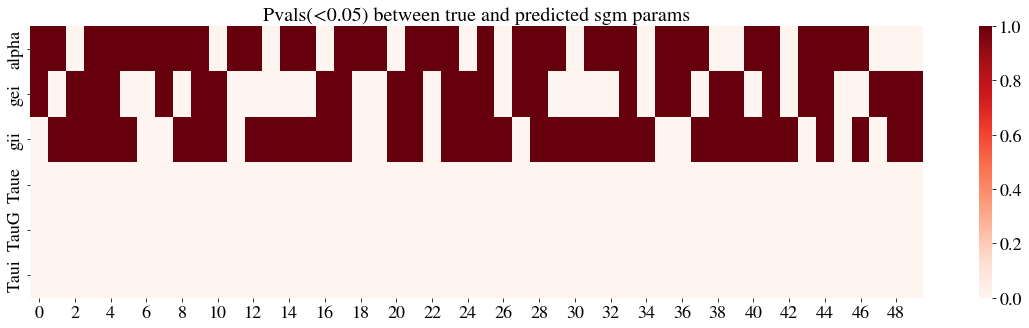

In [36]:
plt.figure(figsize=[20, 5])
plt.title(f"Pvals(<0.05) between true and predicted sgm params", fontsize=20)
sns.heatmap(pvals.T<0.05, cmap="Reds", vmin=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

#### MSE

/tmp/ipykernel_15106/1651260520.py:6: RuntimeWarning: divide by zero encountered in true_divide
  sns.heatmap((mses/stds).T, cmap="Reds", vmin=0, annot=False)


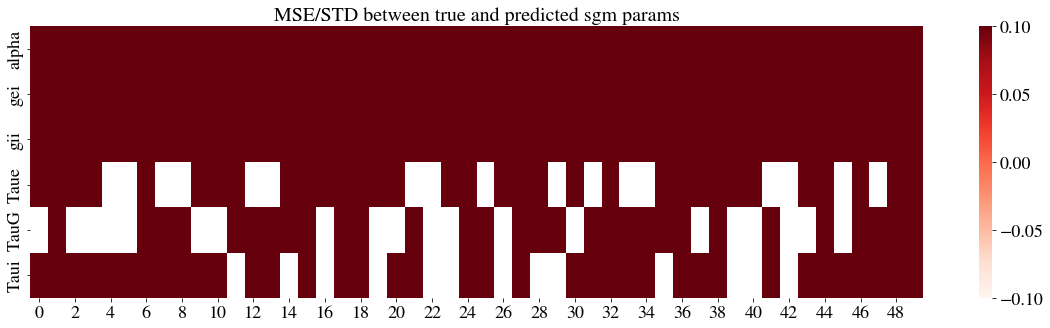

In [37]:
mses = np.mean((true_params_flt - pred_params_flt)**2, axis=1).reshape(-1, num_dyn_params);
stds = true_params_flt.std(axis=1).reshape(-1, num_dyn_params)

plt.figure(figsize=[20, 5])
plt.title(f"MSE/STD between true and predicted sgm params", fontsize=20)
sns.heatmap((mses/stds).T, cmap="Reds", vmin=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

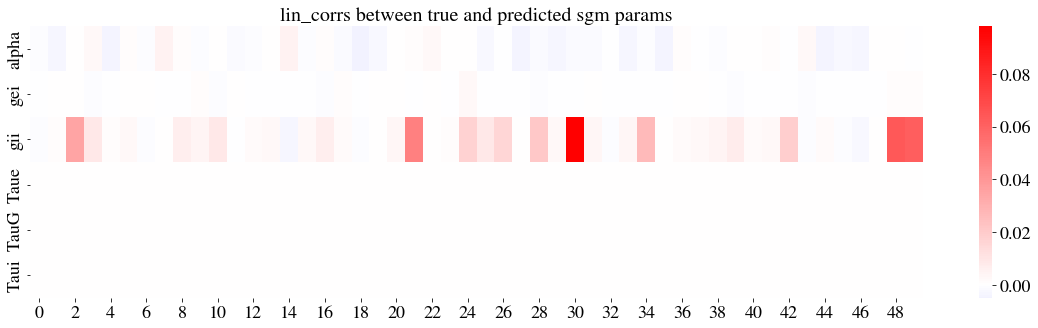

In [38]:
lin_corrs = lin_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);

plt.figure(figsize=[20, 5])
plt.title(f"lin_corrs between true and predicted sgm params", fontsize=20)
sns.heatmap(lin_corrs.T, cmap="bwr", center=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

### Corr between SGM params

In [39]:
corr_mats_pred = np.array([np.corrcoef(pred_params[0, :, dy_mask==1]) for sub_ix in range(pred_params.shape[0])]);
corr_mats_true = np.array([np.corrcoef(true_params[0, :, dy_mask==1]) for sub_ix in range(true_params.shape[0])]);

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


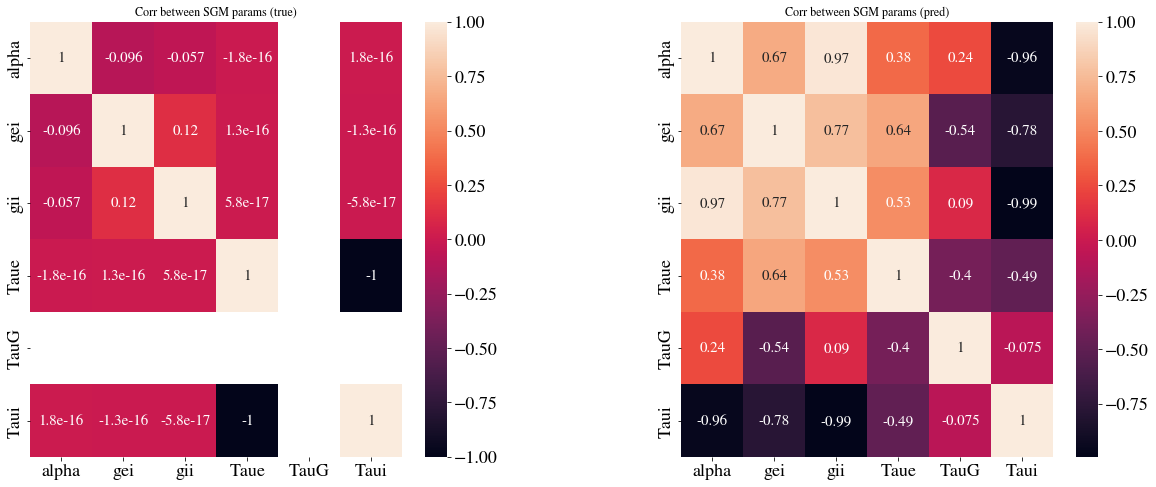

In [40]:
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.title("Corr between SGM params (true)")
sns.heatmap(np.mean(corr_mats_true, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.subplot(122)
plt.title("Corr between SGM params (pred)")
sns.heatmap(np.mean(corr_mats_pred, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);

------

### Recontruct PSD

In [107]:
sgm_net.eval()
with torch.no_grad():
    X_rec1 = sgm_net(Y_pred)
X_rec1 = X_rec1.numpy()

X_org = simu_sgm_data.PSDs
X_org = X_org/X_org.std(axis=(1, 2), keepdims=1)

In [149]:
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
X_rec2 = []
for sgm_params_cur in tqdm(Y_pred):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_params_cur.numpy())
    X_rec2.append(cur_PSD[:68])
X_rec2 = np.array(X_rec2)
X_rec2 = X_rec2/X_rec2.std(axis=(1, 2), keepdims=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:21<00:00,  2.62it/s]


In [109]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    corrs_sp = []
    for ix in range(data_org.shape[1]):
        seq_x = data_org[:, ix]
        seq_y = data_rec[:, ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_sp.append(res[0])
    return corr_psd_uni, corrs_psd, corrs_sp

In [155]:
corrs1 = []
corrs2 = []
for ix in range(len(X_org)):
    corrs1.append(ana_corr(X_org[ix], X_rec1[ix])[0])
    corrs2.append(ana_corr(X_org[ix], X_rec2[ix])[0])
print(np.mean(corrs1), np.std(corrs1))
print(np.mean(corrs2), np.std(corrs2))

0.9484344357956783 0.08743834731049734
0.9369320017806869 0.10136407192723579


In [171]:
print(np.stack([
    np.argsort(corrs1)[:10],
    np.argsort(corrs2)[:10]]))

print(np.stack([
    np.argsort(-np.array(corrs1))[:10],
    np.argsort(-np.array(corrs2))[:10]]))

[[346 482 308 782 551 481 310 109 309 632]
 [482 346 481 782 632 551  45 309 109 308]]
[[284 295 357 336 923 695  87 381 202  86]
 [664 807 715 828 887 405 437 841 164 222]]


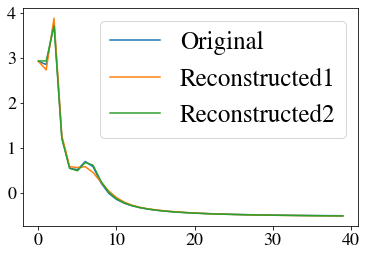

In [177]:
idx = np.argmin(corrs1)
idx = 405 
plt.plot(std_mat(X_org[idx]).mean(axis=0), label="Original")
plt.plot(std_mat(X_rec1[idx]).mean(axis=0), label="Reconstructed1")
plt.plot(std_mat(X_rec2[idx]).mean(axis=0), label="Reconstructed2")
plt.legend()

In [178]:
np.stack([ 
    simu_sgm_data.sgm_paramss[idx],
    Y_pred[idx].numpy()])

array([[6.67153059e-01, 4.68866069e-01, 1.95860934e+00, 1.30077886e-02,
        2.96239173e-02, 1.59695247e-01, 1.47868816e+01],
       [3.77303394e-01, 3.60230355e-01, 7.73818310e-01, 1.28352319e-02,
        2.95342640e-02, 1.12282176e-01, 1.95564955e+01]])

In [135]:
paras.prior_bds

array([[1.e-01, 1.e+00],
       [1.e-03, 7.e-01],
       [1.e-03, 2.e+00],
       [5.e-03, 3.e-02],
       [5.e-03, 3.e-02],
       [5.e-03, 2.e-01],
       [5.e+00, 2.e+01]])

## Save

In [136]:
trained_model = edict()
trained_model.model = rnn
trained_model.loss = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_rnn
trained_model.loss = losses
save_pkl_dict2folder(RES_ROOT/"LSTM_simu_net", trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/paras.pkl
